In [37]:
!pip3 install git+https://github.com/holounic/Bayesian-Optimization.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/holounic/Bayesian-Optimization.git to /tmp/pip-req-build-178dzon2
  Running command git clone -q https://github.com/holounic/Bayesian-Optimization.git /tmp/pip-req-build-178dzon2
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Cloning https://github.com/holounic/pyDOE to /tmp/pip-install-138js4ja/pydoe_7c11c93acd0c4ab98d88b296a6da92a5
  Running command git clone -q https://github.com/holounic/pyDOE /tmp/pip-install-138js4ja/pydoe_7c11c93acd0c4ab98d88b296a6da92a5
     |████████████████████████████████| 316 kB 9.1 MB/s 
     |████████████████████████████████| 62 kB 1.3 MB/s 
  Created wheel for bayes-optim: filename=bayes_optim-0.2.7-py3-none-any.whl size=145056 sha256=6e32a568d35c40f647e66b3533f61396ebaa13d54c1445c2bb4cdb719b36b693
  Stored in directory: /tmp/pip-ephem-wheel-cache-h

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from benchmark.bbobbenchmarks import F12
from bayes_optim.search_space import RealSpace

In [48]:
dim = 2
lb, ub = -5, 5
space = RealSpace([lb, ub]) * dim
f_name = 'f12'
f = F12

samples = space.sample(50000)

In [49]:
def fix_numeric_data(df):
  regrets = [float(x[1:-1]) for x in df['regret'].tolist()]
  df['regret'] = regrets
  return df

In [50]:
def minmax_normalisation():
  minmax = []
  for i in range(50):
    func = f(i)
    minmax.append(func(samples).max() - func.getfopt())
  return minmax

In [54]:
def abs_normalisation():
  n = []
  for i in range(50):
    func = f(i)
    n.append(func(samples).mean() - func.getfopt())
  return n

In [51]:
cma_es = fix_numeric_data(pd.read_csv(f'{f_name}_cma_es_doe_normalized.csv')[['regret', 'f_s']]).rename(columns={'regret': 'cma_es_regret'})
cma_es_init = fix_numeric_data(pd.read_csv(f'{f_name}_lhs_initial_doe_normalized.csv')[['regret', 'f_s']]).rename(columns={'regret': 'lhs_init_regret'})
uniform = fix_numeric_data(pd.read_csv(f'uniform_doe_{f_name}.csv')[['regret', 'f_s']]).rename(columns={'regret': 'uniform_regret'})
lhs = fix_numeric_data(pd.read_csv(f'lhs_doe_{f_name}.csv')[['regret', 'f_s']]).rename(columns={'regret': 'lhs_regret'})
halton = fix_numeric_data(pd.read_csv(f'halton_doe_{f_name}.csv')[['regret', 'f_s']]).rename(columns={'regret': 'halton_regret'})
sobol = fix_numeric_data(pd.read_csv(f'sobol_doe_{f_name}.csv')[['regret', 'f_s']]).rename(columns={'regret': 'sobol_regret'})
stats = cma_es.merge(uniform.merge(lhs.merge(sobol.merge(halton.merge(cma_es_init)))))
stats.head()

,cma_es_regret,f_s,uniform_regret,lhs_regret,sobol_regret,halton_regret,lhs_init_regret
0,7931.797929,0,254.464389,232279.387235,84.596237,58534.371890,1668.853686
1,888.472181,1,448.294770,40006.366296,2230.669884,1133.412513,3070.170670
2,84.181734,2,216.617280,70897.125412,132113.772990,38639.061936,80047.271964
3,3.051259,3,723761.000305,21584.524160,9307.488625,569.838772,1521.362389
4,2198.842823,4,653.594849,269.886182,105.370176,3804.543857,1276.585396


In [55]:
stats['minmax_norm'] = minmax_normalisation()
stats['abs_norm'] = abs_normalisation()
stats.head()

,cma_es_regret,f_s,uniform_regret,lhs_regret,sobol_regret,halton_regret,lhs_init_regret,minmax_norm,abs_norm
0,7931.797929,0,254.464389,232279.387235,84.596237,58534.371890,1668.853686,4.174837e+09,7.345873e+07
1,888.472181,1,448.294770,40006.366296,2230.669884,1133.412513,3070.170670,5.918340e+10,6.067587e+09
2,84.181734,2,216.617280,70897.125412,132113.772990,38639.061936,80047.271964,1.702789e+11,5.495024e+09
3,3.051259,3,723761.000305,21584.524160,9307.488625,569.838772,1521.362389,1.008419e+11,3.621440e+09
4,2198.842823,4,653.594849,269.886182,105.370176,3804.543857,1276.585396,5.599803e+07,9.076027e+06


# CMA-ES vs first individual (generated by LHS)

In [5]:
cma_init = stats.loc[stats['cma_es_regret'] < stats['lhs_init_regret']]
print(f'CMA-ES improved lhs DoE on {cma_init.shape[0]}, ({100 * cma_init.shape[0] / stats.shape[0]}%) function instances')
cma_init[['f_s', 'cma_es_regret', 'lhs_init_regret']]

CMA-ES improved lhs DoE on 24, (48.0%) function instances


,f_s,cma_es_regret,lhs_init_regret
1,1,888.472181,3070.170670
2,2,84.181734,80047.271964
3,3,3.051259,1521.362389
5,5,1616.578948,323909.030910
6,6,1028.769456,49844.708275
13,13,8290.276623,16376.526507
17,17,32.155585,6335.431142
19,19,55.583681,43413.897418
21,21,92.490050,2221.519081
22,22,207.353817,51036.382566


In [6]:
cma_init = stats.loc[stats['cma_es_regret'] > stats['lhs_init_regret']]
print(f'CMA-ES worstened lhs DoE on {cma_init.shape[0]}, ({100 * cma_init.shape[0] / stats.shape[0]}%) function instances')
cma_init[['f_s', 'cma_es_regret', 'lhs_init_regret']]

CMA-ES worstened lhs DoE on 26, (52.0%) function instances


,f_s,cma_es_regret,lhs_init_regret
0,0,7931.797929,1668.853686
4,4,2198.842823,1276.585396
7,7,3111.589288,182.933108
8,8,965.689909,176.659791
9,9,245.253138,87.528454
10,10,2064.526015,29.284710
11,11,150460.150446,34812.382332
12,12,1221.969445,122.367482
14,14,550.309160,195.106312
15,15,4906.454457,19.591288


# CMA-ES generated vs Uniform

In [7]:
cma_uniform = stats.loc[stats['cma_es_regret'] < stats['uniform_regret']]
print(f'DoE generated by CMA-ES is better than uniformly sampled DoE on {cma_uniform.shape[0]}, ({100 * cma_uniform.shape[0] / stats.shape[0]}%) function instances')
cma_uniform[['f_s', 'cma_es_regret', 'uniform_regret']]

DoE generated by CMA-ES is better than uniformly sampled DoE on 24, (48.0%) function instances


,f_s,cma_es_regret,uniform_regret
2,2,84.181734,216.617280
3,3,3.051259,723761.000305
5,5,1616.578948,1731.877363
6,6,1028.769456,54288.215803
9,9,245.253138,918.384788
10,10,2064.526015,4209.118926
14,14,550.309160,9480.907956
16,16,182.152901,1043.255041
18,18,4824.485804,7088.556736
19,19,55.583681,3178.182795


# CMA-ES vs LHS

In [8]:
cma_lhs = stats.loc[stats['cma_es_regret'] < stats['lhs_regret']]
print(f'DoE generated by CMA-ES is better than lhs sampled DoE on {cma_lhs.shape[0]} ({100 * cma_lhs.shape[0] / stats.shape[0]}%) function instances')
cma_lhs[['f_s', 'cma_es_regret', 'lhs_regret']]

DoE generated by CMA-ES is better than lhs sampled DoE on 28 (56.0%) function instances


,f_s,cma_es_regret,lhs_regret
0,0,7931.797929,232279.387235
1,1,888.472181,40006.366296
2,2,84.181734,70897.125412
3,3,3.051259,21584.524160
5,5,1616.578948,192675.044137
6,6,1028.769456,8654.507956
8,8,965.689909,2910.237017
9,9,245.253138,1482.453082
12,12,1221.969445,1919.053412
14,14,550.309160,4705.625654


# CMA-ES vs Sobol

In [9]:
cma_sobol = stats.loc[stats['cma_es_regret'] < stats['sobol_regret']]
print(f'DoE generated by CMA-ES is better than sobol generated DoE on {cma_sobol.shape[0]} ({100 * cma_sobol.shape[0] / stats.shape[0]}%) function instances')
cma_sobol[['f_s', 'cma_es_regret', 'sobol_regret']]

DoE generated by CMA-ES is better than sobol generated DoE on 29 (58.0%) function instances


,f_s,cma_es_regret,sobol_regret
1,1,888.472181,2230.669884
2,2,84.181734,132113.772990
3,3,3.051259,9307.488625
5,5,1616.578948,9549.294594
6,6,1028.769456,119622.038447
8,8,965.689909,21258.304864
10,10,2064.526015,2470.388194
13,13,8290.276623,14617.942600
14,14,550.309160,3555.052797
16,16,182.152901,996.916387


# CMA-ES vs Halton

In [ ]:
cma_halton = stats.loc[stats['cma_es_regret'] < stats['halton_regret']]
print(f'DoE generated by CMA-ES is better than halton generated DoE on {cma_halton.shape[0]} ({100 * cma_halton.shape[0] / stats.shape[0]}%) function instances')
cma_halton[['f_s', 'cma_es_regret', 'halton_regret']]

DoE generated by CMA-ES is better than halton generated DoE on 28 (56.0%) function instances


,f_s,cma_es_regret,halton_regret
3,3,3.043431,3.425719
6,6,7.149106,88.397229
8,8,0.238367,4.290194
11,11,1.198859,2.494132
12,12,0.002897,0.448713
13,13,0.024728,1.034911
14,14,4.101530,5.175030
16,16,3.250321,15.126580
18,18,1.623855,4.358441
19,19,0.028016,2.087634


In [10]:
cma_is_best = stats.loc[(stats['cma_es_regret'] < stats['halton_regret']) & (stats['cma_es_regret'] < stats['uniform_regret']) & (stats['cma_es_regret'] < stats['lhs_regret']) & (stats['cma_es_regret'] < stats['sobol_regret'])]
print(f'DoE generated by CMA-ES is better than any baseline generated DoE on {cma_is_best.shape[0]} ({100 * cma_is_best.shape[0] / stats.shape[0]}%) function instances')
cma_is_best

DoE generated by CMA-ES is better than any baseline generated DoE on 10 (20.0%) function instances


,cma_es_regret,f_s,uniform_regret,lhs_regret,sobol_regret,halton_regret,lhs_init_regret
2,84.181734,2,216.617280,70897.125412,132113.772990,38639.061936,80047.271964
3,3.051259,3,723761.000305,21584.524160,9307.488625,569.838772,1521.362389
14,550.309160,14,9480.907956,4705.625654,3555.052797,14941.192548,195.106312
18,4824.485804,18,7088.556736,32794.645144,121639.385928,8214.973733,1762.070622
19,55.583681,19,3178.182795,91.004268,131.705803,11034.575008,43413.897418
21,92.490050,21,1924.228955,5701.437003,1415.909801,368.169071,2221.519081
24,1846.994684,24,42923.518649,10173.818185,71117.972161,9279.385090,43687.033184
28,334.716313,28,20179.322794,24023.935718,97608.321057,57135.022727,35804.658746
30,34.041542,30,1374.048891,684.556271,5372.965579,3296.692048,272.460999
34,425.511293,34,14148.810354,13535.657187,2732.598067,20378.893229,22890.813067


In [19]:
best_name = 'uniform_regret'
uniform_is_best = stats.loc[(stats[best_name] <= stats['halton_regret']) & (stats[best_name] <= stats['cma_es_regret']) & (stats[best_name] <= stats['lhs_regret']) & (stats[best_name] <= stats['sobol_regret'])  & (stats[best_name] <= stats['uniform_regret'])]
print(f'Uniformly sampled DoE is the best on {uniform_is_best.shape[0]} ({100 * uniform_is_best.shape[0] / stats.shape[0]}%) function instances')
uniform_is_best

Uniformly sampled DoE is the best on 13 (26.0%) function instances


,cma_es_regret,f_s,uniform_regret,lhs_regret,sobol_regret,halton_regret,lhs_init_regret
1,888.472181,1,448.294770,40006.366296,2230.669884,1133.412513,3070.170670
7,3111.589288,7,91.535708,238.598216,944.635886,210.997632,182.933108
8,965.689909,8,611.900511,2910.237017,21258.304864,2445.030659,176.659791
12,1221.969445,12,496.686694,1919.053412,872.481164,718.863844,122.367482
17,32.155585,17,0.240699,546.330954,3197.845877,76.409507,6335.431142
25,79.391133,25,2.844914,59.669392,3417.392066,1260.487337,62.578278
27,21545.346262,27,107.932595,4633.344019,525.916640,5008.201370,24072.852621
35,14645.370278,35,187.856362,55461.998195,1142.769700,1034.102706,790.525080
37,31.860181,37,14.751004,1351.263039,1198.081600,113.091280,188.338577
38,2810.090128,38,93.098723,27005.126271,12229.153436,12555.926448,49667.697471


In [16]:
best_name = 'halton_regret'
halton_is_best = stats.loc[(stats[best_name] <= stats['halton_regret']) & (stats[best_name] <= stats['cma_es_regret']) & (stats[best_name] <= stats['lhs_regret']) & (stats[best_name] <= stats['sobol_regret'])  & (stats[best_name] <= stats['uniform_regret'])]
print(f'Halton sequence is the best on {halton_is_best.shape[0]} ({100 * halton_is_best.shape[0] / stats.shape[0]}%) function instances')
halton_is_best

Halton sequence is the best on 13 (26.0%) function instances


,cma_es_regret,f_s,uniform_regret,lhs_regret,sobol_regret,halton_regret,lhs_init_regret
5,1616.578948,5,1731.877363,192675.044137,9549.294594,483.268226,323909.030910
6,1028.769456,6,54288.215803,8654.507956,119622.038447,87.386737,49844.708275
9,245.253138,9,918.384788,1482.453082,221.027010,29.947892,87.528454
16,182.152901,16,1043.255041,882.214462,996.916387,42.709990,29.181807
29,19385.534307,29,907.049743,2402.539945,11251.697749,289.956409,1609.876368
31,2494.818270,31,12817.447285,23485.906032,69199.702109,142.044203,9528.122642
33,648.511060,33,2829.776578,3069.593724,1027.715472,240.468701,12035.701605
36,3661.400742,36,17698.197594,135.853098,278.942142,22.986269,24.248109
39,284052.966992,39,45441.121985,7815.965304,12981.992117,6236.148732,514.367663
42,26327.589580,42,69904.185057,972.662842,27332.546220,6.147182,28232.343029


In [17]:
best_name = 'lhs_regret'
lhs_is_best = stats.loc[(stats[best_name] <= stats['halton_regret']) & (stats[best_name] <= stats['cma_es_regret']) & (stats[best_name] <= stats['lhs_regret']) & (stats[best_name] <= stats['sobol_regret'])  & (stats[best_name] <= stats['uniform_regret'])]
print(f'LHS is the best on {lhs_is_best.shape[0]} ({100 * lhs_is_best.shape[0] / stats.shape[0]}%) function instances')
lhs_is_best

LHS is the best on 6 (12.0%) function instances


,cma_es_regret,f_s,uniform_regret,lhs_regret,sobol_regret,halton_regret,lhs_init_regret
10,2064.526015,10,4209.118926,1815.326544,2470.388194,14684.993366,29.284710
13,8290.276623,13,248.865789,49.545035,14617.942600,4645.792949,16376.526507
20,15927.832143,20,2464.889943,639.574621,717.781815,861.362252,48.105057
26,408.279085,26,2453.715338,292.084459,22295.867437,4883.311744,69.844634
43,318.477120,43,4036.112142,123.981532,3009.894261,1881.110986,354.202440
47,62176.253383,47,13887.729669,4897.018713,4980.346446,22052.815457,17654.928570


In [18]:
best_name = 'lhs_init_regret'
lhs_init_is_best = stats.loc[(stats[best_name] <= stats['halton_regret']) & (stats[best_name] <= stats['cma_es_regret']) & (stats[best_name] <= stats['lhs_regret']) & (stats[best_name] <= stats['sobol_regret'])  & (stats[best_name] <= stats['uniform_regret'])]
print(f'LHS init is the best on {lhs_init_is_best.shape[0]} ({100 * lhs_init_is_best.shape[0] / stats.shape[0]}%) function instances')
lhs_init_is_best

LHS init is the best on 11 (22.0%) function instances


,cma_es_regret,f_s,uniform_regret,lhs_regret,sobol_regret,halton_regret,lhs_init_regret
8,965.689909,8,611.900511,2910.237017,21258.304864,2445.030659,176.659791
10,2064.526015,10,4209.118926,1815.326544,2470.388194,14684.993366,29.284710
12,1221.969445,12,496.686694,1919.053412,872.481164,718.863844,122.367482
14,550.309160,14,9480.907956,4705.625654,3555.052797,14941.192548,195.106312
15,4906.454457,15,171.878461,391.517444,168.855321,213.292370,19.591288
16,182.152901,16,1043.255041,882.214462,996.916387,42.709990,29.181807
18,4824.485804,18,7088.556736,32794.645144,121639.385928,8214.973733,1762.070622
20,15927.832143,20,2464.889943,639.574621,717.781815,861.362252,48.105057
26,408.279085,26,2453.715338,292.084459,22295.867437,4883.311744,69.844634
39,284052.966992,39,45441.121985,7815.965304,12981.992117,6236.148732,514.367663


In [20]:
best_name = 'sobol_regret'
sobol_is_best = stats.loc[(stats[best_name] <= stats['halton_regret']) & (stats[best_name] <= stats['cma_es_regret']) & (stats[best_name] <= stats['lhs_regret']) & (stats[best_name] <= stats['sobol_regret'])  & (stats[best_name] <= stats['uniform_regret'])]
print(f'Sobol sequence is the best on {sobol_is_best.shape[0]} ({100 * sobol_is_best.shape[0] / stats.shape[0]}%) function instances')
sobol_is_best

Sobol sequence is the best on 8 (16.0%) function instances


,cma_es_regret,f_s,uniform_regret,lhs_regret,sobol_regret,halton_regret,lhs_init_regret
0,7931.797929,0,254.464389,232279.387235,84.596237,58534.371890,1668.853686
4,2198.842823,4,653.594849,269.886182,105.370176,3804.543857,1276.585396
11,150460.150446,11,36302.567934,58841.114036,5935.069212,36689.833272,34812.382332
15,4906.454457,15,171.878461,391.517444,168.855321,213.292370,19.591288
22,207.353817,22,154.648177,137.464041,13.434837,178.494784,51036.382566
23,26161.713221,23,8788.335245,1327.489071,86.793395,31977.575456,6102.359444
32,3570.421820,32,41589.008936,663.169266,55.069964,151.868181,1145.157032
46,3915.414206,46,41435.271852,577.527207,312.664583,406.254312,2841.494219


([<matplotlib.axis.XTick at 0x7f1126373d90>,
 [Text(0, 0, 'cma_es'),
  Text(0, 0, 'lhs_init'),
  Text(0, 0, 'uniform'),
  Text(0, 0, 'halton'),
  Text(0, 0, 'sobol'),
  Text(0, 0, 'lhs')])

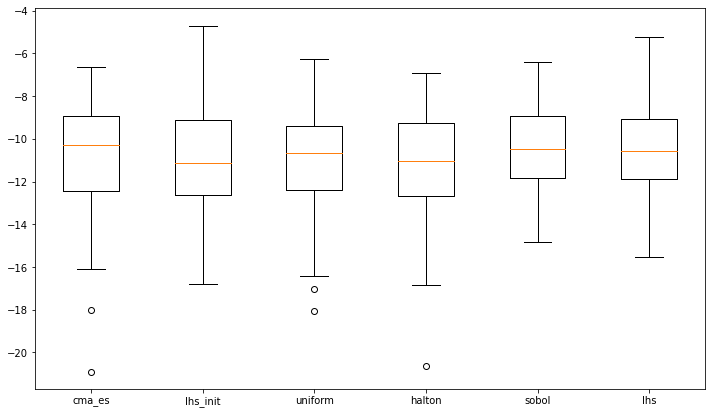

In [60]:
plt.rcParams["figure.figsize"] = (12, 7)

methods = ['cma_es', 'lhs_init', 'uniform', 'halton', 'sobol', 'lhs']
plt.boxplot([np.log(stats[method + '_regret'].div(stats['abs_norm'])) for method in methods])
plt.xticks(list(range(1, len(methods) + 1)), methods)

([<matplotlib.axis.XTick at 0x7f1123770090>,
 [Text(0, 0, 'cma_es'),
  Text(0, 0, 'lhs_init'),
  Text(0, 0, 'uniform'),
  Text(0, 0, 'halton'),
  Text(0, 0, 'sobol'),
  Text(0, 0, 'lhs')])

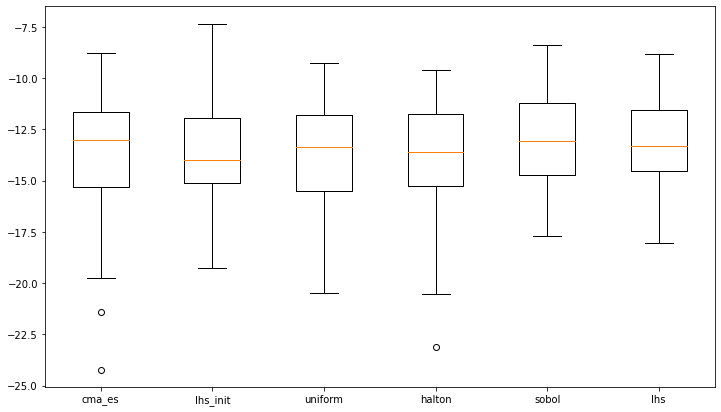

In [61]:
plt.rcParams["figure.figsize"] = (12, 7)

methods = ['cma_es', 'lhs_init', 'uniform', 'halton', 'sobol', 'lhs']
plt.boxplot([np.log(stats[method + '_regret'].div(stats['minmax_norm'])) for method in methods])
plt.xticks(list(range(1, len(methods) + 1)), methods)